### Importing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
import shutil
import random

### Functions

In [8]:
def get_dataframe(set: str, labels_folder: str):
    df = pd.DataFrame(
        {
            "image_name": [],
            "class": [],
            "x_center": [],
            "y_center": [],
            "width": [],
            "height": [],
        }
    )
    train_label_dir = f"dataset/{set}/{labels_folder}"  # Change this to your directory
    for file_path in os.listdir(train_label_dir):
        file_path = os.path.join(train_label_dir, file_path)
        file_name = os.path.basename(file_path)
        image_name = file_name[:-4] + ".jpg"
        with open(file_path, "r", encoding="utf-8") as file:
            lines = file.readlines()
            for line in lines:
                line = line.split(" ")
                class_name = int(line[0])
                x_center = float(line[1])
                y_center = float(line[2])
                width = float(line[3])
                height = float(line[4])
                new_data = pd.DataFrame(
                    {
                        "image_name": [image_name],
                        "class": [class_name],
                        "x_center": [x_center],
                        "y_center": [y_center],
                        "width": [width],
                        "height": [height],
                    }
                )
                df = pd.concat([df, new_data], ignore_index=True)
    df["class"] = df["class"].astype(int)
    return df

In [ ]:
def get_labelled_images(set: str, labelled_images: set):
    # Paths
    source_folder = f"dataset/{set}/images"  # Folder containing all images
    labelled_images_folder = (
        f"dataset/{set}/labelled_images"  # Folder to store images with tumor
    )
    unlabelled_images_folder = (
        f"dataset/{set}/unlabelled_images"  # Folder to store normal images
    )

    # Ensure target directories are empty before copying
    for folder in [labelled_images_folder, unlabelled_images_folder]:
        if os.path.exists(folder):
            shutil.rmtree(folder)  # Delete the folder if it exists
        os.makedirs(folder)  # Recreate an empty folder

    # Iterate through images in the source folder
    for filename in os.listdir(source_folder):

        file_path = os.path.join(source_folder, filename)

        if os.path.isfile(file_path):  # Ensure it's a file
            if filename in labelled_images:
                shutil.copy2(
                    file_path, os.path.join(labelled_images_folder, filename)
                )  
            else:
                shutil.copy2(
                    file_path, os.path.join(unlabelled_images_folder, filename)
                )

In [4]:
def remove_black_bars(set: str, labelled_images: set):

    cropped_images_folder = f"./dataset/{set}/cropped_images"
    cropped_labels_folder = f"./dataset/{set}/cropped_labels"

    for folder in [cropped_images_folder, cropped_labels_folder]:
        if os.path.exists(folder):
            shutil.rmtree(folder)
        os.makedirs(folder)

    for image_name in labelled_images:

        base_image_name = image_name[:-4]
        original_image_path = f"./dataset/{set}/labelled_images/{base_image_name}.jpg"
        original_annotation_path = f"./dataset/{set}/labels/{base_image_name}.txt"
        cropped_image_path = os.path.join(
            cropped_images_folder, f"{base_image_name}.jpg"
        )
        cropped_annotation_path = os.path.join(
            cropped_labels_folder, f"{base_image_name}.txt"
        )

        # Read image
        image = cv.imread(original_image_path)
        H, W, _ = image.shape  # Original dimensions

        # Convert to grayscale & threshold to find the brain region
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        _, binary = cv.threshold(gray, 10, 255, cv.THRESH_BINARY)

        # Find the largest contour (brain)
        contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv.contourArea)
        x, y, w, h = cv.boundingRect(largest_contour)

        # Crop the brain region
        cropped = image[y : y + h, x : x + w]
        new_H, new_W, _ = cropped.shape  # New image size after cropping

        # Center the cropped image by adding black padding
        pad = 20  # Adjust padding as needed
        centered_image = cv.copyMakeBorder(
            cropped, pad, pad, pad, pad, cv.BORDER_CONSTANT, value=[0, 0, 0]
        )
        final_H, final_W, _ = centered_image.shape  # Final image size after centering

        # Read original YOLO annotations
        boxes = []
        with open(original_annotation_path, "r") as f:
            for line in f:
                values = line.strip().split()
                class_id = int(values[0])  # Class label
                x_center, y_center, width, height = map(float, values[1:])

                # Convert YOLO format (normalized) to pixel coordinates
                x1 = int((x_center - width / 2) * W)
                y1 = int((y_center - height / 2) * H)
                x2 = int((x_center + width / 2) * W)
                y2 = int((y_center + height / 2) * H)

                # Adjust coordinates based on the cropped region
                new_x1 = max(0, x1 - x)
                new_y1 = max(0, y1 - y)
                new_x2 = min(w, x2 - x)
                new_y2 = min(h, y2 - y)

                # Add padding offset
                new_x1 += pad
                new_y1 += pad
                new_x2 += pad
                new_y2 += pad

                # Convert back to YOLO format (normalized)
                new_x_center = (new_x1 + new_x2) / 2 / final_W
                new_y_center = (new_y1 + new_y2) / 2 / final_H
                new_width = (new_x2 - new_x1) / final_W
                new_height = (new_y2 - new_y1) / final_H

                boxes.append(
                    f"{class_id} {new_x_center} {new_y_center} {new_width} {new_height}\n"
                )

        # Save updated annotations
        with open(cropped_annotation_path, "w") as f:
            f.writelines(boxes)

        # Save the centered image
        cv.imwrite(cropped_image_path, centered_image)

In [48]:
def draw_bounding_box(set: str, row):
    # Load cropped image
    base_name = row['image_name'][:-4]
    cropped_image_path = f"./dataset/{set}/cropped_images/{base_name}.jpg"

    cropped_image = cv.imread(cropped_image_path)
    H, W, _ = cropped_image.shape  # New image dimensions
    x_center = row['x_center']
    y_center = row['y_center']
    width = row['width']
    height = row['height']

    # Convert YOLO format (normalized) to pixel coordinates
    x1 = int((x_center - width / 2) * W)
    y1 = int((y_center - height / 2) * H)
    x2 = int((x_center + width / 2) * W)
    y2 = int((y_center + height / 2) * H)
    if row['class'] == 0:
        cv.rectangle(cropped_image, (x1, y1), (x2, y2), (0, 255, 0), 1)
    else:
        cv.rectangle(cropped_image, (x1, y1), (x2, y2), (0, 0, 255), 1)
    cv.putText(
        cropped_image,
        str(base_name),
        (x1, y1 - 10),
        cv.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 0, 0),
        1,
    )

    cropped_image = cv.cvtColor(cropped_image, cv.COLOR_BGR2RGB)
    plt.imshow(cropped_image)
    plt.show()
    

### Train set

In [9]:
df_train = get_dataframe("train", "labels")
df_train.to_csv("train.csv", index=False)
df_train.head()

,image_name,class,x_center,y_center,width,height
0,00340_119.jpg,1,0.649452,0.592723,0.073552,0.063380
1,92 (5).jpg,1,0.366784,0.174296,0.132629,0.142019
2,00061_184.jpg,0,0.376174,0.250000,0.092723,0.091549
3,82 (5).jpg,1,0.454812,0.189554,0.078638,0.073944
4,00123_13.jpg,0,0.284624,0.522300,0.245305,0.267606


In [7]:
train_labelled_images = set(df_train["image_name"].unique())
print(len(train_labelled_images))
get_labelled_images("train", train_labelled_images)

878


In [8]:
remove_black_bars("train", train_labelled_images)

In [9]:
cropped_df = get_dataframe("train", "cropped_labels")
cropped_df.to_csv("train_cropped.csv", index=False)
cropped_df.head()

,image_name,class,x_center,y_center,width,height
0,00340_119.jpg,1,0.652174,0.529703,0.076087,0.079208
1,92 (5).jpg,1,0.288079,0.394545,0.225166,0.265455
2,00061_184.jpg,0,0.353222,0.199686,0.114558,0.147799
3,82 (5).jpg,1,0.398773,0.167692,0.122699,0.113846
4,00123_13.jpg,0,0.260563,0.571429,0.295775,0.269841


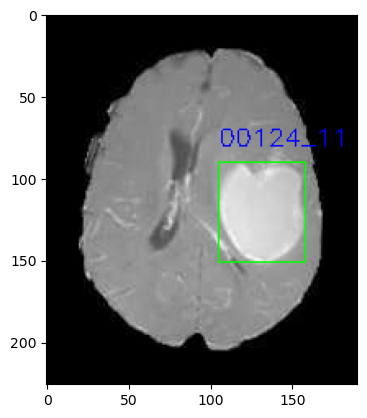

In [51]:
num = random.randint(0, 878) 
draw_bounding_box("train", cropped_df.iloc[num])  # Example image name

### Validation set

In [29]:
df_val = get_dataframe("valid", "labels")
df_val.to_csv("validation.csv", index=False)
df_val.head()

,image_name,class,x_center,y_center,width,height
0,val_1 (174).jpg,0,0.357394,0.237676,0.134977,0.113850
1,val_1 (174).jpg,0,0.524061,0.207160,0.057512,0.045775
2,val_1 (4).jpg,1,0.374413,0.468310,0.180751,0.143192
3,val_1 (58).jpg,0,0.607981,0.321596,0.119718,0.117371
4,val_1 (58).jpg,0,0.708333,0.357981,0.104460,0.105634


In [30]:
valid_labelled_images = set(df_val["image_name"].unique())
print(len(valid_labelled_images))
get_labelled_images("valid", valid_labelled_images)

223


In [31]:
remove_black_bars("valid", valid_labelled_images)

In [32]:
cropped_df_val = get_dataframe("valid", "cropped_labels")
cropped_df_val.to_csv("validation_cropped.csv", index=False)
cropped_df_val.head()

,image_name,class,x_center,y_center,width,height
0,val_1 (174).jpg,0,0.256897,0.468401,0.237931,0.215613
1,val_1 (174).jpg,0,0.551724,0.410781,0.103448,0.085502
2,val_1 (4).jpg,1,0.289125,0.561162,0.244032,0.223242
3,val_1 (58).jpg,0,0.603395,0.422794,0.188272,0.220588
4,val_1 (58).jpg,0,0.762346,0.492647,0.166667,0.198529


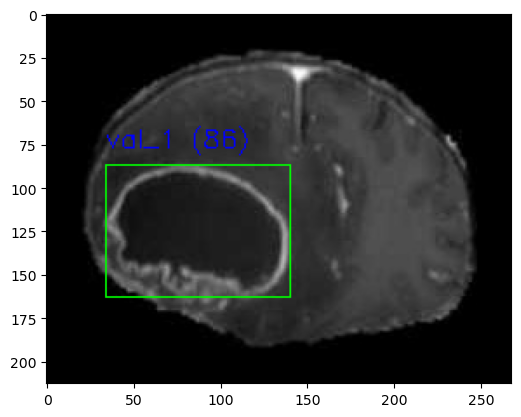

In [49]:
num = random.randint(0, 223) 
draw_bounding_box("valid", cropped_df_val.iloc[num])  # Example image name